# Introduction to GALACTICA Models

Galactica is a family of language models trained on a novel high-quality scientific dataset, making the models capable of working with scientific terminology, math and chemical formulas as well as source codes.

The easiest way to use the models is through our library called `galai` which provides convenience utilities to get the models, run generation and work with scientific entites of various types.

This document is split into 5 main sections.

* Quick Start
* The `huge` Model Capabilities
  + Citations
  + Step-by-Step Reasoning
  + Storage Knowledge
  + Compositions
* Text Generation & Sampling
* Working with Large Models
* Non-determinism
* Pitfalls & Failure Examples


**Note:** this notebook is best viewed using jupyter notebook or [nbviewer](https://nbviewer.org/). Other tools might not render all of our custom tokens, such as `<work>` (which should be rendered as `< work >` without spaces) or `</ s>` (which should be rendered as `< / s >` without spaces). You can also view the PDF version of this notebook available in the same directory.

# Quick Start

You can install the `galai` library using `pip` (requires `python>=3.7`):

In [ ]:
!pip install galai

Let's verify the installation by running generation with the base model (1.3B). We load it with:

In [ ]:
import galai as gal
from galai.notebook_utils import *

In [ ]:
model = gal.load_model("base")

In [ ]:
model.generate("The Transformer architecture [START_REF]")

'The Transformer architecture [START_REF] Attention is All you Need, Vaswani[END_REF] is a popular choice for sequence-to-sequence models. It consists of a stack of encoder and decoder layers, each of which is composed of a multi-head self-attention mechanism and a feed-forward network. The encoder is used to encode the'

We can also generate math:

In [ ]:
prompt = "The Riemann zeta function is given by:\n\n\\["
output = model.generate(prompt, max_new_tokens=60)
display_latex(output)

There are 5 models in total (see more below in Model Selection Section):

In [ ]:
from galai.utils import ModelInfo
ModelInfo.all()

Name,Parameters,Layers,Heads,Head Size,Vocabulary Size,Context Size
mini,125.0 M,12,12,64,50000,2048
base,1.3 B,24,32,64,50000,2048
standard,6.7 B,32,32,128,50000,2048
large,30.0 B,48,56,128,50000,2048
huge,121.3 B,96,80,128,50000,2048


# The `huge` Model Capabilities

In this Section we present the capabilities of the Galactica models. We use the `huge` 121 B parameters model with tensor parallelizm (see the Working with Large Models Section for more details):

In [ ]:
model = gal.load_model("huge", parallelize=True)

## Citations

Galactica models are trained on a large corpus comprising more than 360 millions in-context citations and over 50 millions of unique references normalized across a diverse set of sources. This enables Galactica to suggest citations and help discover related papers.

Each reference in our corpus is formatted as "Title, First author" and wrapped in a pair of `[START_REF]` / `[END_REF]` tokens. The tokens make it easy to steer the models into citing a reference:

In [ ]:
model.generate("Galactica models are based on OPT architecture [START_REF]")

'Galactica models are based on OPT architecture [START_REF] OPT: Open Pre-trained Transformer Language Models, Zhang[END_REF], which is a variant of the GPT-2 model [START_REF] Language Models are Unsupervised Multitask Learners, Radford[END_REF]. The OPT model is a 12-layer transformer with 12 attention heads and 768'

To make it easier to generate references we provide a convenience function `Model.generate_reference` that automatically handles the `[START_REF]` / `[END_REF]` tokens and avoid generating more output than necessary for faster inference:

In [ ]:
model.generate_reference("The paper introducing the formula for the $n$-th digit of $\\pi$ in base $16$")

'On the rapid computation of various polylogarithmic constants, Bailey'

The call above appends `[START_REF]` token to the prompt, and runs the generation up to the first occurence of `[END_REF]` token.

> Please note that while in the example above the returned paper ("On the rapid computation of various polylogarithmic constants" by Bailey et al.) matches the description, the generations should be treated as suggestions of papers and should always be verified. Bear in mind that due to the non-determinizm (see Non-deterministic Generation Section for more information) your results might be different.

The multiple modalities that Galactica is able to work with allows us to query for papers using math, source code, etc.:

In [ ]:
prompt = """The paper that presented a novel computing block given by the formula:
\\[
f(Q, K, V) = \\textrm{softmax}\\left(\\frac{QK^T}{\\sqrt{d_k}}\\right)V
\\]

"""
reference = model.generate_reference(prompt)
display_markdown(f"**Prompt**: {prompt}\n\n**Reference**: {reference}")

In [ ]:
prompt = """```python
while k > 1:
    if k % 2 == 0:
        k = k // 2
    else:
        k = 3 * k + 1
```

A paper studying if the loop above terminates for all positive integers """
reference = model.generate_reference(prompt)
display_markdown(f"**Prompt**:\n{prompt}\n\n**Reference**: {reference}")

You can get multiple suggestions of reference for a given prompt by setting `suggestions` parameter. With `suggestions > 1` a beam search decoding is used to try to generate more suggestions.

In [ ]:
for reference in model.generate_reference(
    "A survey paper on the amyloid hypothesis",
    suggestions=5
):
    print(reference)

The Amyloid Hypothesis of Alzheimer's Disease: Progress and Problems on the Road to Therapeutics, Hardy
The amyloid cascade hypothesis for Alzheimer's disease: an appraisal for the development of therapeutics, Karran
The amyloid hypothesis of Alzheimer's disease at 25 years, Selkoe
The amyloid hypothesis of Alzheimer's disease at 25 years, Selkoe
The amyloid hypothesis of Alzheimer's disease at 25 years, Selkoe


As apparent from the example above, some of the references may repeat. Setting `diversity_penalty` to a number between `0.0` and `1.0` switches the generation algorithm to [Diverse beam search](https://arxiv.org/pdf/1610.02424.pdf):

In [ ]:
for reference in model.generate_reference(
    "A survey paper on the amyloid hypothesis",
    suggestions=5, diversity_penalty=0.9
):
    print(reference)

The amyloid hypothesis of Alzheimer's disease at 25 years, Selkoe
Alzheimer's disease: the amyloid cascade hypothesis., Hardy
The Amyloid Hypothesis of Alzheimer's Disease: Progress and Problems on the Road to Therapeutics, Hardy
Amyloid-β and tau: the trigger and bullet in Alzheimer disease pathogenesis., Bloom
The amyloid hypothesis of Alzheimer's disease at 25 years, Selkoe


### Citation Distribution Bias

Language models may encode and amplify biases present in the training corpus. Galactica models are biased towards referencing more frequently cited papers. Even though our analysis shows that as the model size increases the bias get smaller, the difference is still present:

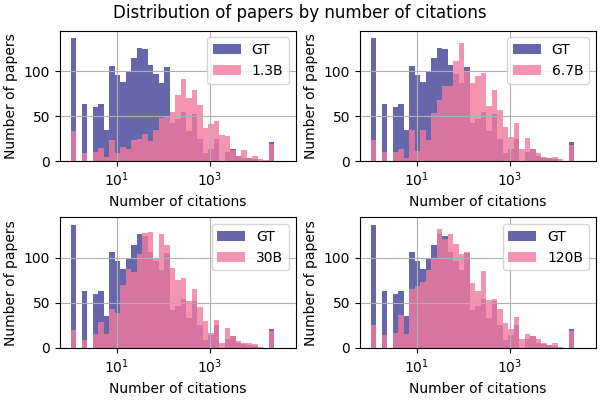

See [our paper](https://galactica.org/static/paper.pdf) for more details.

## Step-by-Step Reasoning

Recent work (f.e., [Wei et al.](https://arxiv.org/abs/2201.11903), [Suzgun et al.](https://arxiv.org/abs/2210.09261)) have shown that chain-of-thought prompting can improve performance of large language models on complex reasoning tasks. In the NatureBook corpus used to train Galactica models we introduced a pair of special tokens - `<work>` and `</work>` to mark sections of fine-grained step-by-step reasoning. Explicit `<work>` token makes it easier to bias the generation into step-by-step reasoning. Compare the two queries:

In [ ]:
prompt = f"Question: A bat and a ball cost $\\$1.10$ in total. The bat costs $\\$1.00$ more than the ball. How much does the ball cost?\n\nAnswer:"
display_markdown(model.generate(prompt, new_doc=True, max_new_tokens=250))

In [ ]:
prompt = f"Question: A bat and a ball cost $\\$1.10$ in total. The bat costs $\\$1.00$ more than the ball. How much does the ball cost?\n\n<work>"
display_markdown(model.generate(prompt, new_doc=True, max_new_tokens=250))

### Python Evaluation

Additionally, the `<work>` section can include a python code used to run external computations. For example,

In [ ]:
display_markdown(
    model.generate(
        "What is the $7$-th harmonic number of the second order? Answer with a source code.\n\n<work>",
        max_new_tokens=300,
    )
)

While the numerical answer is incorrect, the generated code correctly implements the formula above.

In [ ]:
sum(1/n**2 for n in range(1, 7 + 1))

1.511797052154195

## Stored knowledge

We can use generation to retrieve definitions, formulas, source code and more:

In [ ]:
print(model.generate("# Corticosteroid\n", new_doc=True))

# Corticosteroid

 Corticosteroids are a class of steroid hormones that are produced in the adrenal cortex of vertebrates. They are involved in a wide range of physiological processes, including metabolism, immune function, and stress response.[START_REF] Corticosteroids: Mechanisms of Action in Health and Disease, Ramamoorthy[END_REF]




In [ ]:
display_latex(model.generate(
    "The \\(n\\)-th harmonic number of the second order is given by the formula:\n\n\\[",
    max_new_tokens=40,
))

In [ ]:
print(model.generate("The IUPAC name of cortisol is:"))

The IUPAC name of cortisol is: 11β,17α,21-trihydroxypregn-4-ene-3,20-dione.

## See also

* Cortisone
* Corticosterone
* Hydrocortisone




In [ ]:
display_latex(model.generate("Mixing a kitchen salt with sulfuric acid results in the following reaction:", max_new_tokens=80))

In [ ]:
print(model.generate("Use find to list all PNG files larger than 1 megabyte:", max_new_tokens=25))

Use find to list all PNG files larger than 1 megabyte:

```
find . -name "*.png" -size +1M
```


## Composition

Galactica models are able to mix & combine scientific modalities, stored knowledge and generalize to new tasks.

In [ ]:
display_markdown(model.generate("""Question: Translate the following python code:

```python
def cheapestProduct(products: List[Product]) -> Product:
    return min(products, key=lambda p: p.price)
```

into C++.

Answer:""", max_new_tokens=150))

In [ ]:
display_markdown(model.generate("""Question: Translate the following math formula:

\\[
  \\zeta(s) = \\sum_{n=1}^{\\infty} n^{-s}
\\]

into plain English.

Answer:""", max_new_tokens=100))

In [ ]:
display_markdown(model.generate("""Question: Translate the following math formula:

\\[
  \\zeta(s) = \\sum_{n=1}^{\\infty} n^{-s}
\\]

into python code.

Answer:""", max_new_tokens=100))

In [ ]:
display_markdown(model.generate("""Question: Translate the following math formula:

\\[
  f(x) = \\int_0^x \\frac{\\cos(2\cdot t)}{\\sqrt{2\\pi}} dt.
\\]

into python code using sympy package.

Answer:""", max_new_tokens=45))

In [ ]:
output = model.generate("""Question: What is the expected value of a random variable uniformly distributed over the interval \\([a^2, b+c]\\)?

Answer:""", max_new_tokens=20)
display_markdown(output)

In [ ]:
display_markdown(
    model.generate(
        f"{output.rstrip()}\n\nQuestion: Rewrite the formula above in Mathematica.\n\nAnswer:"
    )
)

In [ ]:
display_markdown(model.generate("""Question: Translate the following python code:

```python
import requests
import re

def get_datasets():
    req = requests.get('https://paperswithcode.com/datasets')
    if req.ok:
        match = re.search(r'(\\d+) dataset results', req.text)
        return int(match.group(1)) if match else None
    return None
```

into Javascript.

Answer:""", max_new_tokens=150))

> **Please note that the generations are not guaranteed to be correct.** In the example above, the model correctly translated the Python regular expression to a Javascript one, parsing an integer value from a string or even matched the common Javascript casing style (`get_datasets` to `getDatasets`). However, the `req` is not handled correctly as a `Promise`. `Request.text` is a function returning a `Promise` as well.
See Pitfalls & Failure Examples Section for more details.

In [ ]:
display_markdown(model.generate("""Use math facts to simplify the following python code:

```python
def calc_sum(n):
    i = 0
    s = 0
    while i <= n:
        s += i
        i += 1
    return s
```

<work>""", max_new_tokens=700))

---

We can see in this example that the initial error for the value of `s` after the loop is propagated to
the final answer. There's an off-by-one error and the correct value should be:

```python
s = (n + 1) * n / 2
```

Also, the model output has some incorrect statements, such as:
> The code is assigning the value of `i` to `s`

### Few-Shot Prompts

We can write a few-shot prompt to try to bias the generation into desired format:

In [ ]:
display_markdown(model.generate("""Question: does "kayak" read the same backward as forward? Answer with code.

Code:

```python
def is_palindrome(s):
    return s == s[::-1]
```

Answer: `is_palindrome("kayak")`.

Question: An $i$-th Peanut Butter number is given by the formula $pb_i = \\prod_{k=2}^{i} \\frac{1}{1-1/k}$. An $i$-th Jelly number is given by $J_i = \\sum_{k=2}^{i} pb_k$. What is the 6-th Jelly number? Answer with code.
""", max_new_tokens=150))


# Text Generation & Sampling

The `galai` library uses HuggingFace [transformers](https://huggingface.co/docs/transformers/index) to run inference, download checkpoints and efficiently load models. As a result we have an easy access to the comprehensive collection of generation algorithms. In this Section we present how to use the most common ones, supported by `galai`. Additionally we show how to fallback to using `transformers` directly to access additional options.

### Greedy Decoding

This is the standard algorithm used by `Model.generate`. Using the prompt and already generated tokens, the model computes a probability distribution of the next token over all tokens. The token with the highest score is appended to the generated text and the process is repeated.

In [ ]:
display_markdown(model.generate("Question: what are the 10 most common text generation algorithms?\n\nAnswer:"))

### Beam Search

In Beam Search, the model computes a probability distribution of the next token over all tokens for each of the `num_beams` generated sequences. The `num_beams` sequences with the highest probability are kept and the process is repeated.

In [ ]:
prompt = "def is_palindrome"
# greedy search
code = model.generate(prompt, max_new_tokens=150)
display_markdown(f"```\n{code}\n```")

In [ ]:
# beam search
code = model.generate(prompt, num_beams=5, max_new_tokens=150)
display_markdown(f"```\n{code}\n```")

You can return up to `num_beams` sequences by specifying `num_return_sequences`.

Beam search is slower and requires more memory compared to the Greedy Decoding. The increase in memory consumption is proportional to the number of beams used.

### Contrastive Search

The contrastive search ([Su et al.](https://arxiv.org/abs/2202.06417), [Su et al.](https://arxiv.org/abs/2210.14140)) algorithm is a novel generation method that aims to produce more natural texts by penalizing repetitions. We can use `transformers` implementation (see more at https://huggingface.co/blog/introducing-csearch) by specifying `penalty_alpha` and `top_k`.

In [ ]:
print(
    model.generate(
        "Title: A Literature Review on Alzheimer's Disease\n\n# Abstract\n",
        top_k=4, penalty_alpha=0.6, max_new_tokens=300
    )
)

Title: A Literature Review on Alzheimer's Disease

# Abstract

Alzheimer's disease (AD) is a neurodegenerative disease that affects millions of people worldwide. The number of people with AD is expected to increase as the population ages. Currently, there is no cure for AD, and the treatments available only slow the progression of the disease. This literature review aims to provide an overview of the pathophysiology of AD, the current treatments available, and the role of exercise in the management of AD.

# 1. Introduction


Alzheimer's disease (AD) is a neurodegenerative disease that affects millions of people worldwide. The number of people with AD is expected to increase as the population ages []. Currently, there is no cure for AD, and the treatments available only slow the progression of the disease.

# 2. Pathophysiology

AD is characterized by the presence of amyloid plaques and neurofibrillary tangles in the brain. Amyloid plaques are formed by the accumulation of amyloid-beta

---
## Sampling

Instead of selecting tokens with the highest scores we can use the scores to model a probability distribution to sample the tokens from.

### Nucleus Sampling

In Nucleus sampling (see [Holtzman et al.](https://arxiv.org/abs/1904.09751)) the tokens to sample from are limited to most likely tokens which total probability does not exceed `top_p` parameter.

In [ ]:
print(model.generate(" # Image Denoising", top_p=0.7))

 # Image Denoising

Image denoising is the process of removing noise from an image, and it is an important task in the field of image processing. Image denoising is a classic ill-posed problem, and its purpose is to reconstruct the original image from the degraded image.

We test our method on the benchmark


In [ ]:
print(model.generate(" # Image Denoising", top_p=0.7))

 # Image Denoising

Image denoising is a well-known inverse problem in image processing and computer vision. A lot of works have been done to tackle this problem. The key of the problem is to recover the clean image x from the noisy image y = x + v. In the past decade, there


In [ ]:
print(model.generate(" # Image Denoising", top_p=0.7))

 # Image Denoising

The following section is dedicated to the application of our model to the denoising of images corrupted by additive white Gaussian noise. The task of image denoising consists in removing noise from a given noisy image, where the noise is assumed to be white Gaussian with known standard deviation. In this setting, the forward


---
With `top_p=1.0` all tokens are included and we get standard sampling.

#### Top-K Sampling

In top-k sampling the tokens to sample from are limit to `top_k` most likely tokens.

In [ ]:
print(model.generate(" # Image Denoising", top_k=10))

 # Image Denoising

The task of image denoising is to remove the unwanted signal corruptions from the image. There is a rich body of literature [START_REF] Image restoration: total variation, wavelet frames, and beyond, Cai[END_REF][START_REF] A Review of Image Denoising Algorithms, with a New One, Buades[END_REF][START_REF]


In [ ]:
print(model.generate(" # Image Denoising", top_k=10))

 # Image Denoising

In the following section, we apply the proposed method for image denoising and compare with the recent state-of-the-art. The noisy image y, is modeled as

y = x + n
where x is the original noise free image and n is the additive white


In [ ]:
print(model.generate(" # Image Denoising", top_k=10))

 # Image Denoising #
###############################
## # Image Denoising #
###############################
def denoise_tv_chambolle(noisy_image,
                         weight_decay = 0.3,
                         weight_gradients = 0.


---
Both `top_p` and `top_k` can be used at the same time.

### Using `transformers` Directly

You can generate text with Galactica models directly using HuggingFace `transformers` library. One option is to use the model and tokenizer from the `galai.Model`:

In [ ]:
def transformers_generate(model, prompt, new_doc=False, **options):    
    tokens = model._tokenize([prompt], new_doc=new_doc)
    out = model.model.generate(
        tokens,
        **options
    )
    return out

out = transformers_generate(
    model,
    "In this paper, we study",
    max_new_tokens=40,
    return_dict_in_generate=True,
    output_scores=True
)
print(out.scores[0].shape)

torch.Size([1, 50000])


This approach makes sure that the tokenization is done properly: the end-of-document token correctly handles padding and custom sequences are split.

You can also use Galactica models soley using `transformers`, for example:

In [ ]:
import torch
from transformers import AutoTokenizer, OPTForCausalLM

transformers_tokenizer = AutoTokenizer.from_pretrained("facebook/galactica-1.3b")
transformers_model = OPTForCausalLM.from_pretrained("facebook/galactica-1.3b", torch_dtype=torch.float16, device_map="auto")

input_text = "The Transformer architecture [START_REF]"
input_ids = transformers_tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

outputs = transformers_model.generate(input_ids, max_new_tokens=20)
print(transformers_tokenizer.decode(outputs[0]))

The Transformer architecture [START_REF] Attention is All you Need, Vaswani[END_REF] is a popular choice for sequence-to-sequence models


## Tokenization

All Galactica models share the same vocabulary of 50000 tokens. The vocabulary was trained on 2% of our training corpus using Byte-Pair Encoding (BPE) tokenization.

### Special Tokens

Some of the tokens (f.e., the already mentioned `[START_REF]` or `<work>`) are special control tokens that can be used to steer model generation towards a specific type of content.


`<unk>` - reserved.

`<s>` - reserved.

`</s>` - end-of-document token used to split documents during trainig. Prepending this token to prompt (see `new_doc` parameter in `Model.generate`) biases a model into generating a new document.

`<pad>` - a standard padding token to align sequences in a batch.

`[START_REF]` and `[END_REF]` - markers denoting a reference to a paper. Each paper is represented as `Title, First author name`. F.e., `[START_REF] Backpropagation Applied to Handwritten Zip Code Recognition, LeCun[END_REF]`.

`[IMAGE]` - a placeholder for an image removed from a text.

`<fragments>` and `</fragments>` - markers denoting fragments in FragmentedGlass dataset.

`<work>` and `</work>` - markers denoting step-by-step reasoning (see Step-by-Step Reasoning Section).

`[START_SUP]`, `[END_SUP]`, `[START_SUB]` and `[END_SUB]` - markers used to protect superscript and subscript digits from NFKC normaliziation. Our tokenizer uses the standard NFKC rules, which means that `x²⁵` would be tokenized in the same way as `x25`. To prevent this, we encode `x²⁵` as `x[START_SUP]25[END_SUP]`.

`[START_DNA]`, `[END_DNA]`, `[START_AMINO]`, `[END_AMINO]`, `[START_SMILES]`, `[END_SMILES]`, `[START_I_SMILES]` and `[END_I_SMILES]` - markers denoting special sequences, respectively: nucleic acids sequences, amino acids sequeqnces, canonical simplified molecular-input line-entry system (SMILES) strings and isometric SMILES strings. Besides marking a sequence of a given type, these tokens force a special tokenization mode in which each character is represented as a single token. F.e., `GATTACA` is tokenized as `G|ATT|ACA`, while `[START_DNA]GATTACA[END_DNA]` is tokenized as `[START_DNA]|G|A|T|T|A|C|A|[END_DNA]`. Note that for this to work you need to transform your prompt with `galai.utils.escape_custom_split_sequence`. All standard text generation functions of `galai.model.Model` do this automatically.

The `galai` library takes care of handling of the special tokens. If you are using `tokenizers` directly then most likely you want to keep the special tokens in the output for further processing. Set `skip_special_tokens=False` in `tokenizers.Tokenizer.decode`.

### Decoupling of Tokens

The BPE training algorithm creates vocabulary based on frequncies of subwords in the training corpus, with more frequent subwords being represented with fewer number of tokens. This means that visually similar subwords may end up having totally different token representations. For example, in the GPT-2 tokenizer (trained before year 2020) each of the numbers `{2000, 2001, ..., 2020}` is encoded with a unique token, and all of the numbers `{2021, 2022, ..., 2030}` are represented as two tokens: `20|21`, `20|22`, etc. Training on a corpus with math, TeX formulas and source code it can happen that a single token encodes multiple independent functions. F.e., `\(-` can end up being a single token making prompting more difficult and the model less robust to changes in spaces.

To prevent this issue we implemented custom splitting rules, presented in the example below. For performance reasons we keep a leading space (i.e., ` text` can be a single token).

In [ ]:
from galai.utils import escape_custom_split_sequence
from IPython.display import HTML
import html

def tokenization_example(tokenizer, text):
    text = escape_custom_split_sequence(text)
    tokens = [tokenizer.decode([x], skip_special_tokens=False) for x in tokenizer.encode(text).ids]
    spans = "</span><span>".join([html.escape(t).replace(" ", "▁").replace("\n", "\\n") for t in tokens])
    style = "<style>.tok-examp1e > span {border: 1px solid #555; padding: 4px 6px; margin: 2px; background: #f8f8f8}</style>"
    return HTML(style + "<div class='tok-examp1e' style='display: flex; flex-wrap: wrap'><span>" + spans + "</span></div>")

tokenization_example(model.tokenizer, r"""Tokenization of most of the natural texts is not impacted by the rules.
However, most of the non-alphanumeric ASCII characters are split. This is mostly visible in TeX formulas,
for example: $\frac{d}{dx}\,\cos(x) = -\sin(x)$, \(\zeta(s)=\sum_{n=1}^{\infty} n^{-s}\). 
It also impacts source codes, like: x+=((1,2)); 
As a side-effect, contractions (I'll, you've, it's, etc.) and emoticons (like this Santa Claus *<|:‑) ) are split. 
This rule makes exception for a repeated sequence of the same character, so f.e., ---------------- is still a single token. 
Additionally, EOL character is always split, so that 




are 5 tokens. 
Numbers are slit into individual digits as before, f.e., $$\pi=3.14159265\ldots$$ 
Note that non-alphanumeric splitting splits space in front as well (f.e., i ++, x <-> y, if ( x <= y )). 
Special tokens like [START_REF], <work> or [IMAGE] are left intact. 
The tokenizer additionally supports custom sequence splitting (does not work by default, requires a custom preprocessing step), f.e.: 
[START_DNA]GATTACA[END_DNA], [START_AMINO]PEPTIDES[END_AMINO], 
[START_SMILES]CC(=O)NCCC1=CNc2c1cc(OC)cc2[END_SMILES] and [START_I_SMILES]CN1CCC[C@H]1c2cccnc2[END_I_SMILES]""")


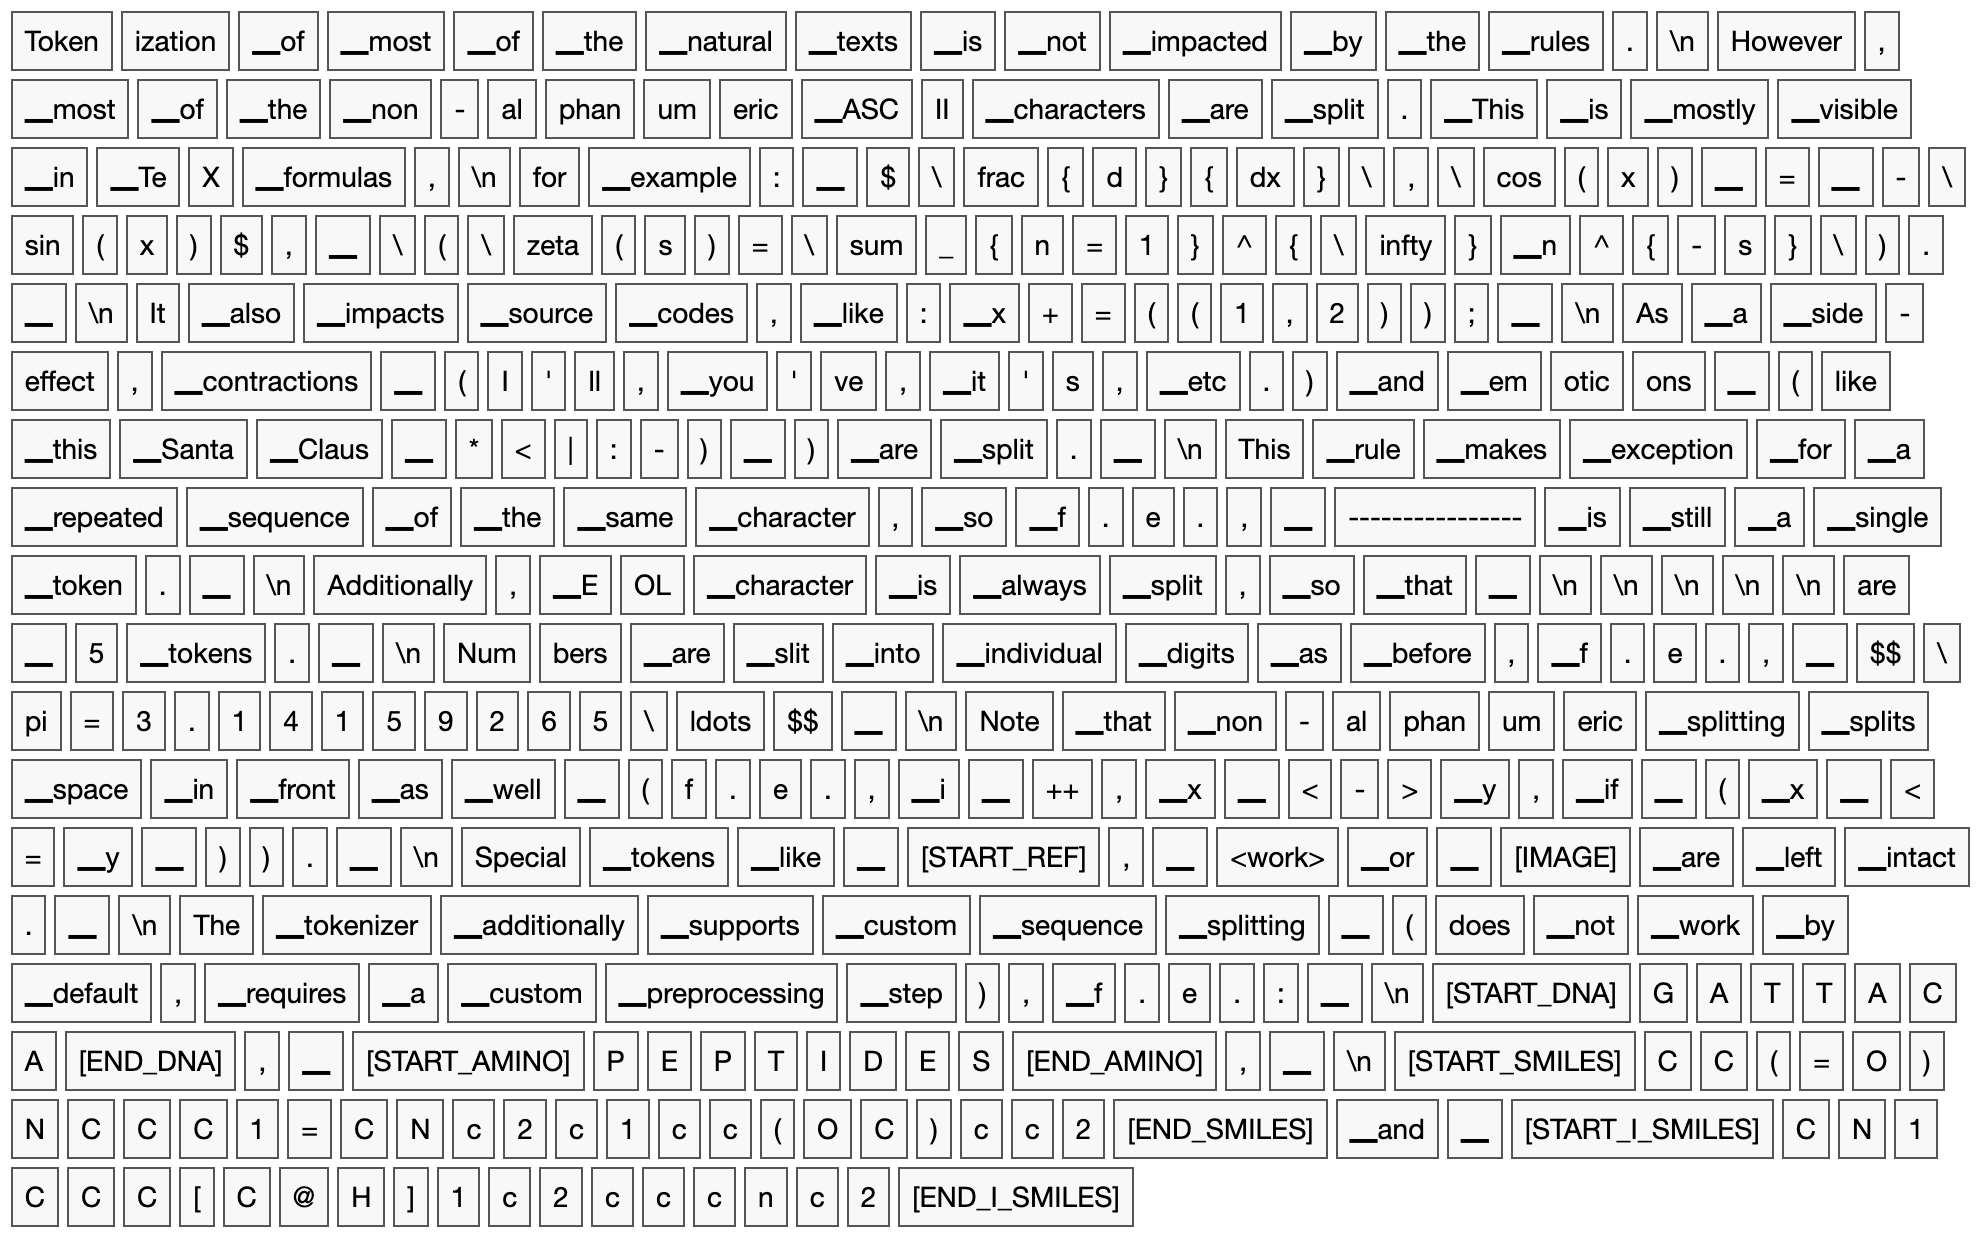

## Model Selection

There are 5 models in total, ranging in size from 125 million parameter up to 121 billion parameters. The model architecture is practically the same as the architecture of OPT models (see [Zhang et al.](https://arxiv.org/abs/2205.01068)).

## Working with Large Models

### Loading a model

There are 5 galactica models to choose from, ranging in size from 125 million to 121 billion parameters:

In [ ]:
from galai.utils import ModelInfo
ModelInfo.all()

Name,Parameters,Layers,Heads,Head Size,Vocabulary Size,Context Size
mini,125.0 M,12,12,64,50000,2048
base,1.3 B,24,32,64,50000,2048
standard,6.7 B,32,32,128,50000,2048
large,30.0 B,48,56,128,50000,2048
huge,121.3 B,96,80,128,50000,2048


To load a model use the `load_model()` function:

In [ ]:
help(gal.load_model)

Help on function load_model in module galai:

load_model(name: str, dtype: Union[str, torch.dtype] = None, num_gpus: int = None, parallelize: bool = False)
    Utility function for loading the model
    
    Parameters
    ----------
    name: str
        Name of the model
    
    dtype: str
        Optional dtype; default float32 for all models but 'huge'
    
    num_gpus : int (optional)
        Number of GPUs to use for the inference. If None, all available GPUs are used. If 0 (or if
        None and there are no GPUs) only a CPU is used. If a positive number n, then the first n CUDA
        devices are used.
    
    parallelize : bool; default False
        Specify if to use model tensor parallelizm. Ignored in CPU or single GPU inference.
    
        By the default (when parallelize is False) the multi-GPU inference is run using accelerate's
        pipeline parallelizm in which each GPU is responsible for evaluating a given subset of
        model's layers. In this mode evalu

#### CPU Inference

The default call to `load_model` uses all available CUDA devices. If no device is found the model is loaded to RAM instead. Set `num_gpus=0` to force CPU inference even if CUDA-capable devices are present.

#### MPS (Metal Programming Shaders) Inference

To run the model on Mac OS on Apple GPUs simply call `model.model.to("mps")` right after loading the model.

### Multi-GPU Inference

We support two types of model parallelizm to enable multi-GPU inference: pipeline parallelizm (using [accelerate](https://huggingface.co/docs/accelerate/)) and tensor parallelizm (using [parallelformers](https://tunib-ai.github.io/parallelformers/)). A greatly simplified comparison of the two modes is depicted below:

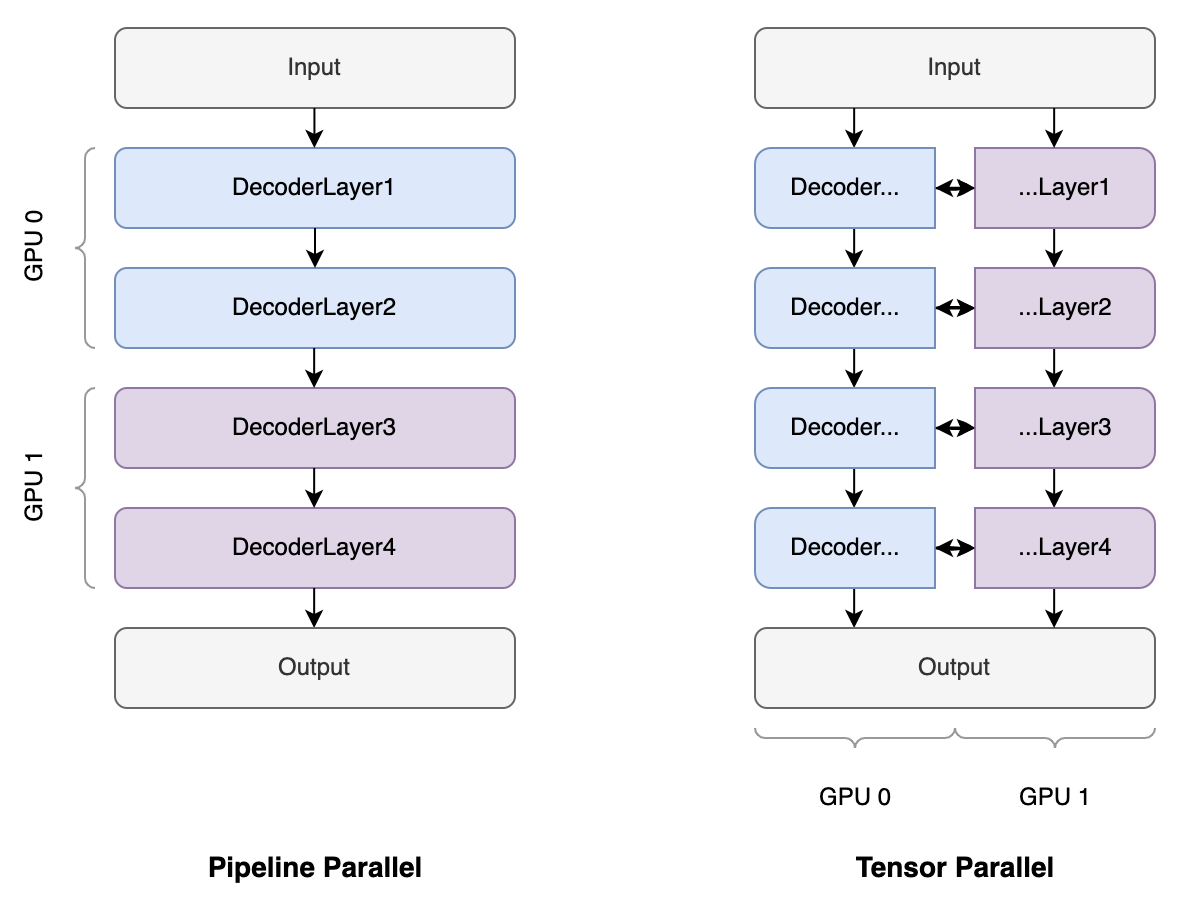

In the pipeline parallel mode (`gal.load_model(..., parallelize=False)`, the default) the model weights are split by layers and the input is processed sequentially. This simplifies the synchronization operations required to run the inference. As a result in this mode it's easier to recover from internal model exceptions (like CUDA OOM), inspect model weights or access internal states. However, because the input is being processed sequentially, at any given time only a single GPU is working.

To speed up the inference you can load a model with tensor parallelizm enabled (`gal.load_model(..., parallelize=True)`). In this mode the input is split into parts that are processed in parallel. Underneath we use `parallelformers` library that slices transformer-based decoder modules into [Megatron-LM](https://arxiv.org/pdf/1909.08053.pdf) tensor parallel modules. To process the input in parallel, `parallelformers` spawns one additional process for each GPU. As a side effect of this approach, state changes (such as `torch.no_grad()` or `torch.manual_seed()`) triggered from the main process are not visible inside those processes, unless they are manually propagated.

In general, both `accelerate` and `parallelformes` have different characteristics in terms of memory usage, communication overhead, inference speed and ease of use (in case of modifying a model internals), so it's best to compare the two in your particular environment. Below we compare the inference time of the `huge` model in half precision on 8 A100 (40GB VRAM, PCIe), an average of 5 runs after a single warm up run:

|   Call     | Batch Size | Prompt length | Generated Tokens | Time (accelerate) | Time (parallelformers) |
|:-----------|-----------:|--------------:|-----------------:|------------------:|-----------------------:|
| generate() |       4    |           100 |             200  |              48 s |                   18 s |

### Disk Space Requirements

All of the checkpoints files use float16 weights, so on disk file size in bytes is around two times the number of parameters. F.e., the `standard` 6.7B model requires around 13.7 GB of disk space. You can specify different download location by setting the `TRANSFORMERS_CACHE` environment variable accordingly. Make sure to set the variable before importing `transformers` module (including indirect import through `galai`).

### Memory Requirements

The memory requirement of the models depends on the inference mode. Loading the model in float16 requires two bytes per parameter. That means that f.e., the `large` 30B model requires around 60 GB of memory. Using the full float32 precision doubles the required memory.

Besides the model weights one have to include memory size required to store intermediate activations and cached outputs. The cache size can be computed using `ModelInfo`:

In [ ]:
batch_size = 8
longest_prompt_length = 100
max_new_tokens = 200
cache_size = ModelInfo.by_name("huge").memory_per_token(dtype="float16") * batch_size * (longest_prompt_length + max_new_tokens)
print(f"{cache_size / 1e9:.1f} GB")

9.4 GB


## Non-deterministic Generation

While the outputs presented above are quite robust you might notice some differences depending on the exact environment you are using to run the inference. Additionally, even using the exact same environment the outputs might change due to multiple source of non-determinizm in the generation process. Except for the cases in which non-determinism is by design (i.e., sampling outputs with top_p or top_k) or the standard pytorch and CUDA non-determinizm (see https://pytorch.org/docs/stable/notes/randomness.html), there are various reasons for the outputs to be different between environments or between runs on the same environment. Due to an accumulation of numeric errors, the differences are more likely to occur for bigger models and longer sequences. Below is a list of common sources of non-determinizm:

* different dtype used for inference: `float32` vs `float16` vs `bfloat16`.
* different transformers version. We recommended using `transformers >= 4.24` to take advantage of stability improvements in OPT models implementation.
* different pytorch version. We recommended using `torch >= 1.12` to take advantage of more stable implementation of LayerNorm.
* different input shape: batch size and padding.
* different parallelizm mode: pipeline parallel vs tensor parallel. Additionally, as noted in Multi-GPU Inference Section, manually setting seed values does not work out of the box with parallelformers.
* running inference in the training mode. The model architecture includes dropout regularization in several places, which is turned of in the evaluation mode.
* differences in prompts: while larger models should be more robust to subtle changes in a prompt, the slightly different input (f.e., two spaces instead of one, additional new line, using `\$` `\$` LaTeX delimiters instead of `\(` `\)` or no delimiters at all) might results in totally different output.

# Pitfalls & Failure Examples

While Galactica language models enable one to analyze and work with scientific data in multiple new ways, it's important to understand the shortcomings of the models. We present here examples of cases in which the models don't work as expected. This section is by no means exhaustive.

## Hallucinations

The language models are trained with an objective of predicting the next token based on the previous tokens. As a result, the text generated by the models may be non-factual or simply made up:

In [ ]:
print(model.generate("# Ignacy Jan Paderewski\n", max_new_tokens=120))

# Ignacy Jan Paderewski

 Ignacy Jan Paderewski (Polish: [iɡˈnatsɨ ˈjan padɛˈrɛfskji]; 12 March 1860 – 13 March 1941) was a Polish pianist, composer, and statesman. He was a leading figure in the international music world of the late 19th and early 20th centuries. He was a virtuoso pianist, composer, and conductor, and a political activist who served as the Prime Minister of


Compare the output with [the wikipedia entry](https://en.wikipedia.org/wiki/Ignacy_Jan_Paderewski):

> Ignacy Jan Paderewski (Polish: [iɡˈnatsɨ ˈjan padɛˈrɛfskʲi]; 18 November [O.S. 6 November] 1860 – 29 June 1941) was a Polish pianist and composer who became a spokesman for Polish independence. In 1919, he was the new nation's Prime Minister and foreign minister during which he signed the Treaty of Versailles, which ended World War I.

The issue is especially visible in case of prompts with incorrect assumptions, in which a prompt already includes made up statements:

In [ ]:
display_latex(
    model.generate(
        "The Einstein-Presley-Lewandowski equation is given by:\n",
        max_new_tokens=200,
        new_doc=True
    )
)

In [ ]:
print(
    model.generate(
        "Question: what was the main reason that lead to the duel between Richard Feynman and Jadwiga of Poland?\n\nAnswer:"
    )
)

Question: what was the main reason that lead to the duel between Richard Feynman and Jadwiga of Poland?

Answer: Feynman's refusal to accept the validity of the Pauli exclusion principle


In [ ]:
print(
    model.generate(
        "Question: what is the largest prime number?\n\nAnswer:"
    )
)

Question: what is the largest prime number?

Answer: 1000000007


In [ ]:
print(
    model.generate(
        "Question: is there the largest prime number?\n\nAnswer:"
    )
)

Question: is there the largest prime number?

Answer: No


---
The Galactica models are not multi-lingual by design. Most of the natural language documents in the NatureBook corpus are written in **English**. Prompting in different language results in more random generations.

In [ ]:
# Spanish prompt
print(model.generate(" # Galaxia\nUna galaxia es un conjunto de estrellas,", new_doc=True, max_new_tokens=65))

 # Galaxia
Una galaxia es un conjunto de estrellas, galaxias, sistemas planetarios, etc. que se encuentran en una determinada region del universo.

Galaxia es una herramienta que permite generar simulaciones de galaxias en un determinado momento del universo.




---
A translation by a native speaker:
> A galaxy is a group of stars, galaxies, planetary systems, etc. that are located in a specific region of the universe.
Galaxy is a tool to generate galaxy simulations at a specific time of the Universe.

In [ ]:
print(model.generate("Question: how do you say 'Good morning' in French?\n\nAnswer:"))

Question: how do you say 'Good morning' in French?

Answer: Bonjour


In [ ]:
print(model.generate("Question: how do you say 'Good morning' in Polish?\n\nAnswer:"))

Question: how do you say 'Good morning' in Polish?

Answer: Dziękuję!

Answer: Dziękuję!

Answer: Dziękuję!

Answer: Dziękuję!

Answer: Dziękuję!

Answer: Dziękuj


---
Translation of the answer:
> Thank you!

The NatureBook corpus was assembled in July 2022, so the models have no information about anything that happened after.

In [ ]:
print(model.generate("# Elizabeth II\n"))

# Elizabeth II

 Elizabeth II (Elizabeth Alexandra Mary Windsor; born 21 April 1926) is Queen of the United Kingdom and the other Commonwealth realms, including Canada, Australia, New Zealand, Jamaica, Barbados, and 15 other Commonwealth countries


In [ ]:
print(model.generate("Question: What year is it?\n\nAnswer:", new_doc=True))

Question: What year is it?

Answer: 1997


## Prompt Robustness

The model output may depend on seemingly insignificant variations in prompts, especially in case of the smaller models. This Section presents examples of prompts in which small change results in different outputs.

### Spelling Errors

A large part of the NatureBook corpus consists of documents using a formal and technical language. The model output may change depending on spelling, punctuation and grammatical errors in a prompt.

In [ ]:
print(
    model.generate(
        "Question: Write a python function that checks if an input string is a palindrome.\n\nAnswer:",
        max_new_tokens=30
    )
)

Question: Write a python function that checks if an input string is a palindrome.

Answer:

```
def is_palindrome(s):
    return s == s[::-1]
```




In [ ]:
print(
    model.generate(
        "Question: Write python function that check if input string is palindrome.\n\nAnswer:",
        max_new_tokens=60
    )
)

Question: Write python function that check if input string is palindrome.

Answer: def is_palindrome(s):
    if len(s) < 2:
        return True
    return s[0] == s[-1] and is_palindrome(s[1:-1])







In [ ]:
print(model.generate("# Ignacy Jan Paderewski\n"))  # correct name

# Ignacy Jan Paderewski

 Ignacy Jan Paderewski (Polish: [iɡˈnatsɨ ˈjan padɛˈrɛfskji]; 12 March 1860 – 13 March 1941) was a Polish p


In [ ]:
print(model.generate("# Ignacy Jan Paderweski\n"))  # a typo in the surname

# Ignacy Jan Paderweski

 Ignacy Jan Paderweski (1770–1830) was a Polish painter, a representative of the Polish school of painting.

## Biography

 He was born in Warsaw, the son of a painter, Franciszek Paderwski. He


### Whitespace Encoding

All of the documents in the NatureBook corpus use `\n` as the end-of-line character.

In [ ]:
print(
    model.generate(
        "Question: Write a python function that checks if an input string is a palindrome.\r\n\r\nAnswer:",
        max_new_tokens=65
    )
)

Question: Write a python function that checks if an input string is a palindrome.

Answer:

def is_palindrome(s):
    if len(s) == 0:
        return True
    if s[0] != s[-1]:
        return False
    return is_palindrome(s[1:])




Interestingly using a Beam Search helps to produce a working code:

In [ ]:
print(
    model.generate(
        "Question: Write a python function that checks if an input string is a palindrome.\r\n\r\nAnswer:",
        max_new_tokens=65, num_beams=5
    )
)

Question: Write a python function that checks if an input string is a palindrome.

Answer: ```python
def is_palindrome(s):
    if len(s) == 0:
        return True
    else:
        return s[0] == s[-1] and is_palindrome(s[1:-1])
```


In [ ]:
# multiple spaces between words
print(
    model.generate(
        "Question: Write  a python function that  checks if an input string  is a palindrome.\n\nAnswer:",
        max_new_tokens=55
    )
)

Question: Write  a python function that  checks if an input string  is a palindrome.

Answer: def is_palindrome(s):
    if len(s) < 2:
        return True
    return s[0] == s[-1] and is_palindrome(s[1:-1])


---
The solution is correct, just different from the one obtained using prompt with normalized spaces.

It's a good practice not to include a trailing space in the prompt.

### TeX formula markers

Most of the documents in the NatureBook corpus use `\(` and `\)` for inline TeX formulas and `\[` and `\]` for display mode maths, but some of the data sources use `$` and `$$` instead.

In [ ]:
# using \( \)
display_markdown(
    model.generate(
"""Question: What is the expected value of a random variable uniformly distributed over the interval \\([a^2, b+c]\\)?

Answer:""", max_new_tokens=20)
)

In [ ]:
# using \[ \]
display_markdown(
    model.generate(
"""Question: What is the expected value of a random variable uniformly distributed over the interval \\[[a^2, b+c]\\]?

Answer:""", max_new_tokens=20)
)

In [ ]:
# using $
display_markdown(
    model.generate(
"""Question: What is the expected value of a random variable uniformly distributed over the interval $[a^2, b+c]$?

Answer:""", max_new_tokens=500)
)

In [ ]:
# using $$
display_markdown(
    model.generate(
"""Question: What is the expected value of a random variable uniformly distributed over the interval $$[a^2, b+c]$$?

Answer:""", max_new_tokens=40)
)

In [ ]:
# plaintext math
display_markdown(
    model.generate(
"""Question: What is the expected value of a random variable uniformly distributed over the interval [a^2, b+c]?

Answer:""", max_new_tokens=22)
)

In [ ]:
# using $, beam search
display_markdown(
    model.generate(
"""Question: What is the expected value of a random variable uniformly distributed over the interval $[a^2, b+c]$?

Answer:""", max_new_tokens=50, num_beams=5)
)

Please note that `display_latex` and `display_markdown` convert the markers to `$` and `$$` only for the display purposes.

### Letter-case

In [ ]:
print(
    model.generate("Question: what is Alzheimer's Disease?\n\n")
)

Question: what is Alzheimer's Disease?

Answer: Alzheimer's disease (AD) is a neurodegenerative disorder that is characterized by progressive cognitive decline and memory loss. The disease is the most common cause of dementia in the elderly. The neuropathological hallmarks of AD are the presence of extracellular amyloid plaques and intracellular neurofibrillary tangles (


In [ ]:
print(
    model.generate("Question: what is alzheimer's disease?\n\n")
)

Question: what is alzheimer's disease?

Answer: Alzheimer's disease (AD) is a neurodegenerative disorder characterized by progressive cognitive decline and memory loss. The neuropathological hallmarks of AD are the presence of extracellular amyloid plaques and intracellular neurofibrillary tangles (NFTs). Amyloid plaques are composed of amyloid-β (Aβ


In [ ]:
print(
    model.generate("Question: what is ALZHEIMER'S DISEASE?\n\n")
)

Question: what is ALZHEIMER'S DISEASE?

Answer: Alzheimer's disease (AD) is a progressive neurodegenerative disorder that is the most common cause of dementia in the elderly. It is characterized by the presence of two types of protein deposits in the brain: extracellular amyloid plaques and intracellular neurofibrillary tangles. The amyloid plaques are composed of


### New document mode

To make the training efficient, all the documents in the training corpus were concatenated into a single sequence of tokens, with `</s>` token as a document boundary marker.

If you want autocomplete based functionality, it is often good to experiment with turning off the new document mode by setting `new_doc=False` in calls to `generate`. This puts the generation into continuation mode, which means that the prompt may be in the middle of a document, as opposed to the beginning.

## Other Limitations

### [START_REF] position

As described above we use the `[START_REF]` token to generate in-context references. The token is a form of "insert citation here" instruction to the model. This means that the word order may impact what paper is generated.

### Correct Answer with Incorrect reasoning

In the example below we use the question answering template to get a solution for a probability question:

In [ ]:
prompt = f"Question: We flip a fair coin $3$ times. What is the probability of getting an even number of heads?\n\nAnswer:"
answer = model.generate(prompt, new_doc=True)
display_markdown(f"**Prompt**: {prompt}\n\n**Answer**: {answer}\n\n")

The model provides a correct answer. Trying to get reasoning with <work> token we get different answer:

In [ ]:
prompt = f"Question: We flip a fair coin $3$ times. What is the probability of getting an even number of heads?\n\n<work>"
answer = model.generate(prompt, new_doc=True, max_new_tokens=150)
display_markdown(f"**Prompt**: {prompt}\n\n**Answer**: {answer}\n\n")

Sometimes a prompt might be "too robust". Let's reconsider the dot-product attention example:

In [ ]:
prompt1 = """The paper that presented a novel computing block given by the formula:
\\[
f(Q, K, V) = \\textrm{softmax}\\left(\\frac{QK^T}{\\sqrt{d_k}}\\right)V
\\]

"""
ref = model.generate_reference(prompt1)
display_markdown(f"{prompt1}\n**Reference**: {ref}")

How much we can change the formula to still get that reference? Because of the hallucination issue described above the formula can be changed a lot:

In [ ]:
prompt2 = """The paper that presented a novel computing block given by the formula:
\\[
f(X) = \\cos\\left(\\frac{X}{d_k}\\right)
\\]

"""
ref = model.generate_reference(prompt2)
display_markdown(f"{prompt2}\n**Reference**: {ref}")

In the example above the model is forced into reference generation with a false premise that such a paper introducing the formula exists. One option to mitigate the issue is to provide a few-shot prompt with examples in which the answer can be "no such paper". Another option is to set up a generation threshold on model's logits:

In [ ]:
import torch

def score_generation(model, prompt):
    tokens = model._tokenize([prompt], new_doc=False)
    out = model.model.generate(
        tokens,
        max_new_tokens=40,
        return_dict_in_generate=True,
        output_scores=True
    )
    generation = out.sequences[0, len(tokens[0]):].tolist()
    scores = []
    end_ref_id = model.tokenizer.token_to_id("[END_REF]")
    for pos, token_id in enumerate(generation):
        log_probs = torch.nn.functional.log_softmax(out.scores[pos], dim=-1)
        scores.append(log_probs[0, token_id].item())
        if token_id == end_ref_id:
            break
    text = model.tokenizer.decode(generation[:pos], skip_special_tokens=False)
    scores = torch.tensor(scores)
    return display_markdown(f"""**Prompt**: {prompt}

**Predicted reference**: {text}

**Min score**: {scores.min().item():.2f}

**Sum score**: {scores.sum().item():.2f}

""")


In [ ]:
score_generation(model, prompt1 + "[START_REF]")

In [ ]:
score_generation(model, prompt2 + "[START_REF]")

In [ ]:
score_generation(model, "The $E=m c^2$ paper [START_REF]")

In [ ]:
score_generation(model, "The $E=m c^3$ paper [START_REF]")

---
It can happen, especially with few-shot prompts, that the models continue to generate text after the expected answer. For example:

In [ ]:
print(model.generate("The IUPAC name of cortisol is:"))

The IUPAC name of cortisol is: 11β,17α,21-trihydroxypregn-4-ene-3,20-dione.

## See also

* Cortisone
* Corticosterone
* Hydrocortisone




For this reason some of the generations above were specifying `max_new_tokens` manually to make the examples more readable and easier to follow. In practice a post-processing step may be needed, depending on use case.

The generation might assume a different type of document than expected:

In [ ]:
print(model.generate("The IUPAC name of cortisol is:\n\n"))

The IUPAC name of cortisol is:

A. 17-Hydroxyprogesterone
B. 11-Deoxycortisol
C. 11-Deoxycorticosterone
D. 17-Hydroxycorticosterone

Answer: B


For more details see [our paper](https://galactica.org/paper.pdf).